In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# statistical modules for statistical tests
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [2]:
# download historical 1 minute data for BTC and ETH for Decmber 25th
data = yf.download(tickers="BTC-USD ETH-USD", start="2022-12-25", end="2022-12-26", interval='1m')
data.head()

[*********************100%***********************]  2 of 2 completed


Adj Close                      Close  \
                                BTC-USD      ETH-USD       BTC-USD   
Datetime                                                             
2022-12-24 23:00:00+00:00  16841.931641  1220.094238  16841.931641   
2022-12-24 23:01:00+00:00  16841.677734  1219.893188  16841.677734   
2022-12-24 23:02:00+00:00  16840.859375  1219.827881  16840.859375   
2022-12-24 23:03:00+00:00  16838.943359  1219.735474  16838.943359   
2022-12-24 23:04:00+00:00  16841.343750  1220.108643  16841.343750   

                                                High               \
                               ETH-USD       BTC-USD      ETH-USD   
Datetime                                                            
2022-12-24 23:00:00+00:00  1220.094238  16841.931641  1220.094238   
2022-12-24 23:01:00+00:00  1219.893188  16841.677734  1219.893188   
2022-12-24 23:02:00+00:00  1219.827881  16840.859375  1219.827881   
2022-12-24 23:03:00+00:00  1219.735474  16838.943359  1219.735474   
2022-12-24 23:04:00+00:00  1220.108643  16841.343750  1220.108643   

                                    Low                       Open  \
                                BTC-USD      ETH-USD       BTC-USD   
Datetime                                                             
2022-12-24 23:00:00+00:00  16841.931641  1220.094238  16841.931641   
2022-12-24 23:01:00+00:00  16841.677734  1219.893188  16841.677734   
2022-12-24 23:02:00+00:00  16840.859375  1219.827881  16840.859375   
2022-12-24 23:03:00+00:00  16838.943359  1219.735474  16838.943359   
2022-12-24 23:04:00+00:00  16841.343750  1220.108643  16841.343750   

                                         Volume          
                               ETH-USD  BTC-USD ETH-USD  
Datetime                                                 
2022-12-24 23:00:00+00:00  1220.094238        0       0  
2022-12-24 23:01:00+00:00  1219.893188        0       0  
2022-12-24 23:02:00+00:00  1219.827881        0       0  
2022-12-24 23:03:00+00:00  1219.735474  2747392  316928  
2022-12-24 23:04:00+00:00  1220.108643  1296384  272128

In [3]:
# convert the datetimeindex into only minutes
t_0 = data.index[0]
time = [(time - t_0).seconds/60 for time in data.index]
time[-1] = 1440
data.index = time
t = data.index

In [4]:
# extract the adjusted close price for each minute
data = data['Adj Close']
btc = data['BTC-USD']
eth = data['ETH-USD']
data.head()

,BTC-USD,ETH-USD
0.0,16841.931641,1220.094238
1.0,16841.677734,1219.893188
2.0,16840.859375,1219.827881
3.0,16838.943359,1219.735474
4.0,16841.343750,1220.108643


## Plot prices of BTC and ETH

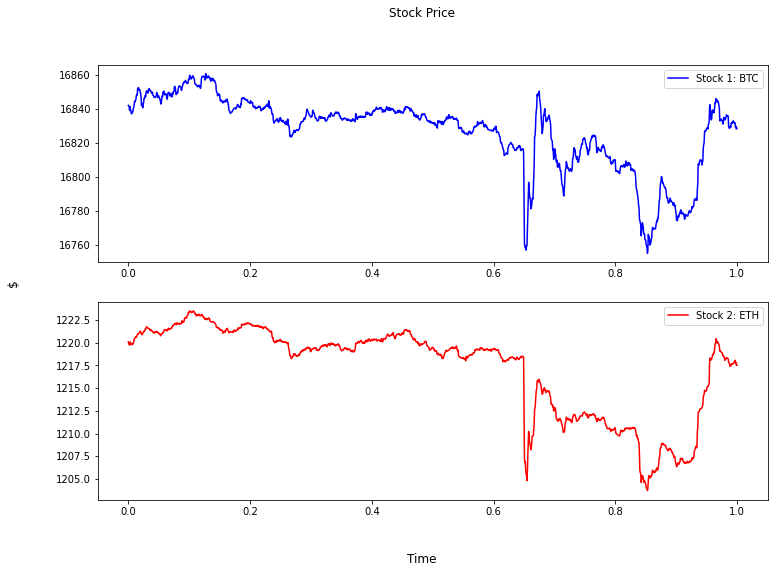

In [5]:
fig, ax = plt.subplots(2, figsize=(12,8))
ax[0].plot(t/1440, btc, 'b', lw=1.5, label='Stock 1: BTC')
ax[1].plot(t/1440, eth, 'r', lw=1.5, label='Stock 2: ETH')
fig.supxlabel('Time')
fig.supylabel('$')
fig.suptitle('Stock Price')
ax[0].legend()
ax[1].legend()

### Cointegrating vector

the integrating vector can be obtained using OLS regression between the log of the assets prices, since the integrating vector is a linear regression equation of the log of both asset prices

In [6]:
log_S2 = eth.apply(lambda x: np.log(x))
log_S1 = btc.apply(lambda x: np.log(x))

log_S2 = sm.add_constant(log_S2)
results = sm.OLS(log_S1, log_S2).fit()
log_S2 = log_S2["ETH-USD"]

beta = -1 * results.params['ETH-USD']
a = -1 * results.params['const']

z = a + log_S1 + beta*log_S2
print(beta)

-0.29553452405853137


In [7]:
results.params

const      7.631160
ETH-USD    0.295535
dtype: float64

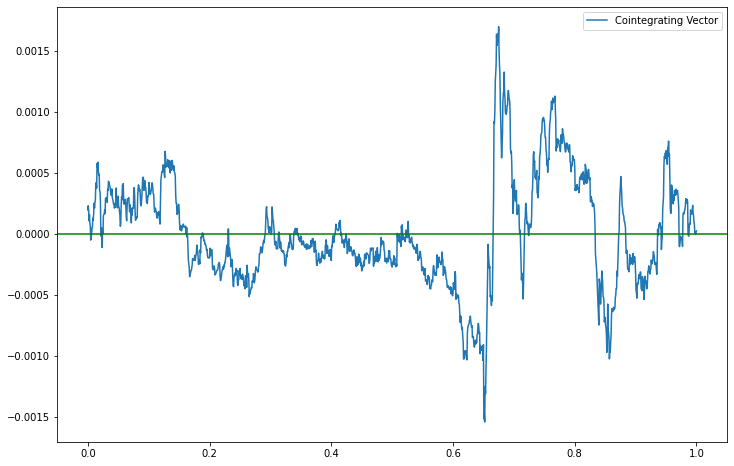

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(t/1440, z)
plt.axhline(z.mean(), color='green')
plt.legend(['Cointegrating Vector']);

### Cointegration tests

In [9]:
score, pvalue, _ = coint(btc, eth, autolag='t-stat')
print('AEG p-value: ', pvalue)

AEG p-value:  0.0016427887577276676


In [10]:
adf_result = adfuller(z, autolag='t-stat')
print('p value of adfuller cointegration test: ', adf_result[1])
print('critical values: \n', adf_result[4])

p value of adfuller cointegration test:  0.0002785492820391903
critical values: 
 {'1%': -3.434979825137732, '5%': -2.8635847436211317, '10%': -2.5678586114197954}


In [11]:
rho = btc.corr(eth)
print('Correlation: ' + str(rho))

Correlation: 0.9405386784221195


### volatility

In [12]:
# BTC volatility as std of log returns of BTC
# 1440 mins per day

sigma_1 = btc.pct_change().apply(lambda x: np.log(1+x)).std() * np.sqrt(1440)
print('volatility: ', round(sigma_1*100,3),'%')

volatility:  0.441 %


In [13]:
# BTC volatility as std of log returns of BTC
# 1440 mins per day

sigma_2 = eth.pct_change().apply(lambda x: np.log(1+x)).std() * np.sqrt(1440)
print('volatility: ', round(sigma_2*100,3),'%')

volatility:  0.93 %


### drift terms

In [14]:
# assuming a constant drift, the drift can be estimated algebraically 
# over the time period of 1 day

mu_1 = ((np.log(btc.iloc[-1]) - np.log(btc.iloc[0]))/1440 + (sigma_1**2)/2) * 1440
mu_2 = ((np.log(eth.iloc[-1]) - np.log(eth.iloc[0]))/1440 + (sigma_2**2)/2) * 1440
print('btc drift: ',mu_1,'\neth drift: ', mu_2)

btc drift:  0.013212979997446727 
eth drift:  0.06015640899197636


### remaining model parameters

In [16]:
gamma = 0.5
T = 1
dt = T/1440
delta = 1

In [17]:
# long run equilibrium value
eta = -(1/delta) * (mu_1 - 0.5*sigma_1**2 + beta*(mu_2 - 0.5*sigma_2**2))
print(eta)

0.004562265178434461


### Optimal trading weights

In [ ]:
# eliminate loop by relying on vectorized operations in pandas

a = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
b = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
c = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
Pi_1 = (1 / btc) * ((mu_1 + delta * z)/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a * (mu_1 + delta * z)-b) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
Pi_2 = (1 / eth) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + (delta * beta / gamma) * (- 2 * a * (mu_1 + delta * z) - b) - rho * (mu_1 + delta * z) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

w1 = Pi_1 * btc
w2 = Pi_2 * eth

Text(0.5, 1.0, 'Weights')

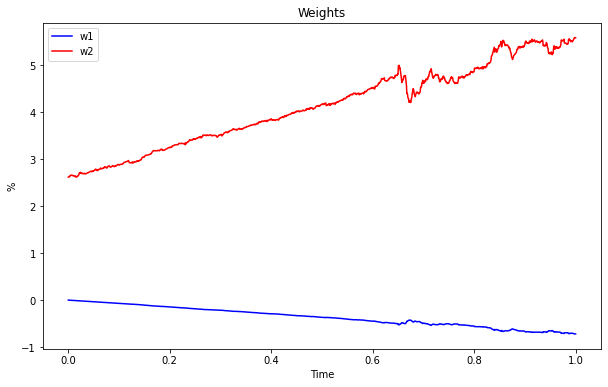

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t*dt, Pi_1, 'b', lw=1.5, label='w1')
plt.plot(t*dt, Pi_2, 'r', lw=1.5, label='w2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Weights')

Text(0.5, 1.0, 'Wealth')

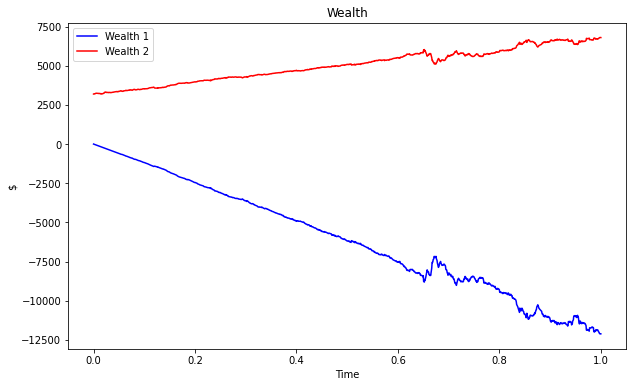

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t*dt, w1, 'b', lw=1.5, label='Wealth 1')
plt.plot(t*dt, w2, 'r', lw=1.5, label='Wealth 2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Wealth')

Text(0.5, 1.0, 'Comparison')

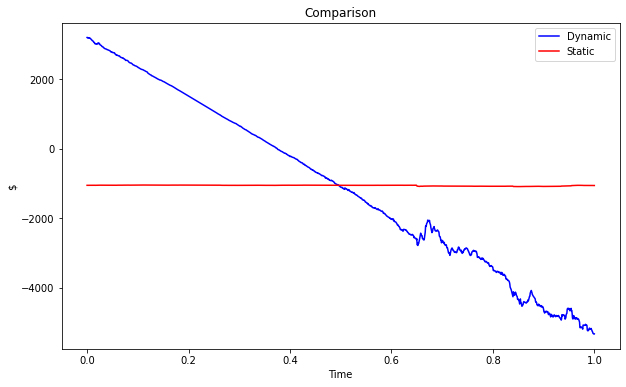

In [ ]:
# compare  results with static control pair

plt.figure(figsize=(10, 6))
plt.plot(t*dt, w1 + w2, 'b', lw=1.5, label='Dynamic')
plt.plot(t*dt, Pi_1.mean() * btc + Pi_2.mean() * eth, 'r', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Comparison')